<a href="https://colab.research.google.com/github/sabari6203/DL_Playground/blob/main/Sequences/Classifying_names_with_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
import zipfile

In [2]:
import torch

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [3]:
from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
txt_path = data_path / "text"


In [4]:
with open("data.zip", "wb") as f:
        request = requests.get("https://download.pytorch.org/tutorial/data.zip")
        print("Downloading data...")
        f.write(request.content)

  # Unzip pizza, steak, sushi data
with zipfile.ZipFile("data.zip", "r") as zip_ref:
    print("Unzipping...")
    zip_ref.extractall(txt_path)

  # Remove .zip file
os.remove("data.zip")

Unzipping...


In [5]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [6]:
print (f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")

converting 'Ślusàrski' to Slusarski


In [7]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [8]:
print (f"The letter 'a' becomes {lineToTensor('a')}") #notice that the first position in the tensor = 1
print (f"The name 'Ahn' becomes {lineToTensor('Ahn')}") #notice 'A' sets the 27th index to 1

The letter 'a' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')
The name 'Ahn' becomes tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 

In [9]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset

class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [10]:
alldata = NamesDataset("/content/data/text/data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([12], device='cuda:0'), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0.

In [11]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


# RNN

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [24]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [25]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.7763, -2.9710, -2.9237, -2.8984, -2.9244, -2.9508, -2.9496, -2.7725,
         -2.9031, -2.9385, -3.0236, -2.9472, -2.9086, -2.8311, -2.8340, -2.8185,
         -2.7713, -2.9317]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('English', 16)


In [28]:
import torch
import torch.nn as nn
import time
import random
import numpy as np
import matplotlib.pyplot as plt

def evaluate(rnn, data, criterion):
    """
    Evaluates the model on a dataset and returns average loss
    """
    rnn.eval()
    total_loss = 0
    with torch.no_grad():
        for label_tensor, text_tensor, label, text in data:
            output = rnn(text_tensor)
            loss = criterion(output, label_tensor)
            total_loss += loss.item()
    return total_loss / len(data)

def train(rnn, training_data, test_data, n_epoch=10, n_batch_size=64, report_every=1, learning_rate=0.2, criterion=nn.NLLLoss()):
    """
    Train the RNN and also evaluate test loss at each epoch
    """
    current_loss = 0
    train_losses = []
    test_losses = []

    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"Training on dataset with n = {len(training_data)}")

    for epoch in range(1, n_epoch + 1):
        rnn.train()
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch:
                label_tensor, text_tensor, label, text = training_data[i]
                output = rnn(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        avg_train_loss = current_loss / len(batches)
        train_losses.append(avg_train_loss)

        avg_test_loss = evaluate(rnn, test_data, criterion)
        test_losses.append(avg_test_loss)

        if epoch % report_every == 0:
            print(f"Epoch {epoch}/{n_epoch}:\tTrain Loss = {avg_train_loss:.4f}\tTest Loss = {avg_test_loss:.4f}")

        current_loss = 0

    # Plotting
    plt.plot(range(1, n_epoch + 1), train_losses, label='Train Loss')
    plt.plot(range(1, n_epoch + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss')
    plt.grid(True)
    plt.show()

    return train_losses, test_losses


Training on dataset with n = 17063
Epoch 5/27:	Train Loss = 0.6438	Test Loss = 0.7925
Epoch 10/27:	Train Loss = 0.5471	Test Loss = 0.7667
Epoch 15/27:	Train Loss = 0.4679	Test Loss = 0.7836
Epoch 20/27:	Train Loss = 0.4177	Test Loss = 0.8112
Epoch 25/27:	Train Loss = 0.3789	Test Loss = 0.8338


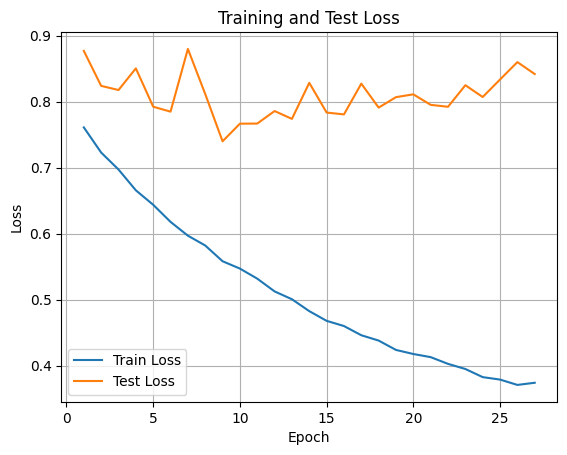

Training took 481.70 seconds


In [29]:
start = time.time()

train_losses, test_losses = train(
    rnn,
    training_data=train_set,
    test_data=test_set,     # make sure you pass this
    n_epoch=27,
    learning_rate=0.15,
    report_every=5
)

end = time.time()
print(f"Training took {end - start:.2f} seconds")


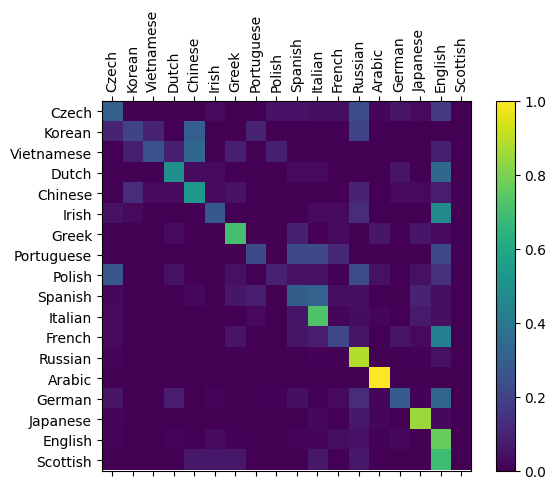

In [31]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_uniq)

# LSTM

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, line_tensor):
        lstm_out, (hidden, cell) = self.lstm(line_tensor)
        out = self.dropout(hidden[-1])
        out = self.h2o(out)
        return self.softmax(out)

In [13]:
n_hidden = 128
lstm = CharLSTM(n_letters, n_hidden, len(alldata.labels_uniq))
print(lstm)

CharLSTM(
  (lstm): LSTM(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [14]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

In [24]:
import torch
import torch.nn as nn
import time
import random
import numpy as np
import matplotlib.pyplot as plt

def evaluate(rnn, data, criterion):
    """
    Evaluates the model on a dataset and returns average loss
    """
    rnn.eval()
    total_loss = 0
    with torch.no_grad():
        for label_tensor, text_tensor, label, text in data:
            output = rnn(text_tensor)
            loss = criterion(output, label_tensor)
            total_loss += loss.item()
    return total_loss / len(data)

def train(lstm, training_data, test_data, n_epoch=10, n_batch_size=64, report_every=1, learning_rate=0.2, criterion=nn.NLLLoss()):
    """
    Train the LSTM and also evaluate test loss at each epoch
    """
    current_loss = 0
    train_losses = []
    test_losses = []

    lstm.train()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    start = time.time()
    print(f"Training on dataset with n = {len(training_data)}")

    for epoch in range(1, n_epoch + 1):
        lstm.train()
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch:
                label_tensor, text_tensor, label, text = training_data[i]
                output = lstm(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            batch_loss.backward()
            nn.utils.clip_grad_norm_(lstm.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        avg_train_loss = current_loss / len(batches)
        train_losses.append(avg_train_loss)

        avg_test_loss = evaluate(lstm, test_data, criterion)
        test_losses.append(avg_test_loss)

        if epoch % report_every == 0:
            print(f"Epoch {epoch}/{n_epoch}:\tTrain Loss = {avg_train_loss:.4f}\tTest Loss = {avg_test_loss:.4f}")

        current_loss = 0

    # Plotting
    plt.plot(range(1, n_epoch + 1), train_losses, label='Train Loss')
    plt.plot(range(1, n_epoch + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss')
    plt.grid(True)
    plt.show()

    return train_losses, test_losses


Training on dataset with n = 17063
Epoch 5/27:	Train Loss = 0.9266	Test Loss = 0.9166
Epoch 10/27:	Train Loss = 0.7029	Test Loss = 0.7439
Epoch 15/27:	Train Loss = 0.5697	Test Loss = 0.6801
Epoch 20/27:	Train Loss = 0.4751	Test Loss = 0.6199
Epoch 25/27:	Train Loss = 0.4024	Test Loss = 0.6167


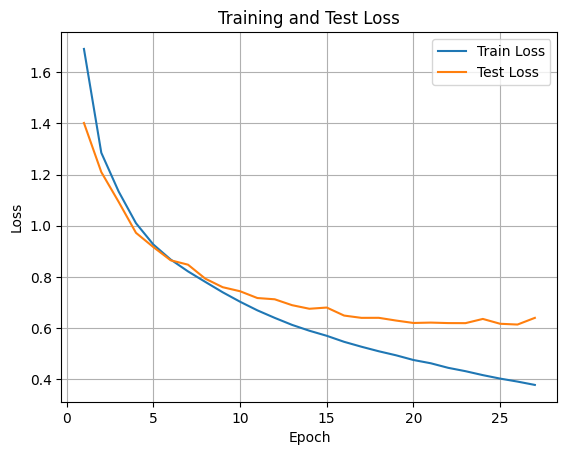

Training took 636.09 seconds


In [25]:
start = time.time()

train_losses, test_losses = train(
    lstm,
    training_data=train_set,
    test_data=test_set,     # make sure you pass this
    n_epoch=27,
    learning_rate=0.001,
    report_every=5
)

end = time.time()
print(f"Training took {end - start:.2f} seconds")


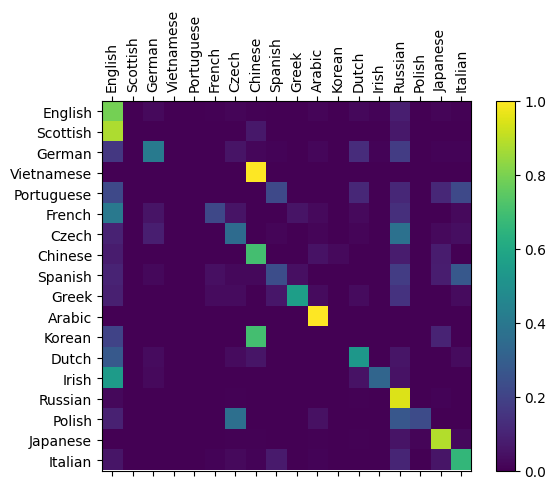

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(lstm, test_set, classes=alldata.labels_uniq)

# with early stopping

In [29]:
def train(lstm, training_data, test_data, n_epoch=30, n_batch_size=64, report_every=5,
          learning_rate=0.001, criterion=nn.NLLLoss(), patience=5):

    current_loss = 0
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0

    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

    for epoch in range(1, n_epoch + 1):
        lstm.train()
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        for batch in batches:
            batch_loss = 0
            for i in batch:
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = lstm(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            batch_loss.backward()
            nn.utils.clip_grad_norm_(lstm.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()
            current_loss += batch_loss.item() / len(batch)

        avg_train_loss = current_loss / len(batches)
        train_losses.append(avg_train_loss)
        current_loss = 0

        # Evaluate on test set
        lstm.eval()
        test_loss = 0
        with torch.no_grad():
            for (label_tensor, text_tensor, label, text) in test_data:
                output = lstm(text_tensor)
                loss = criterion(output, label_tensor)
                test_loss += loss.item()
        avg_test_loss = test_loss / len(test_data)
        test_losses.append(avg_test_loss)

        if epoch % report_every == 0:
            print(f"Epoch {epoch}/{n_epoch}:\tTrain Loss = {avg_train_loss:.4f}\tTest Loss = {avg_test_loss:.4f}")

        # Early stopping check
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            epochs_no_improve = 0
            best_model_state = lstm.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break

    # Load best model before returning
    lstm.load_state_dict(best_model_state)

    return train_losses, test_losses


In [30]:
start = time.time()
train_losses, test_losses = train(
    lstm,
    training_data=train_set,
    test_data=test_set,
    n_epoch=30,
    learning_rate=0.001,
    report_every=5,
    patience=5  # stop if no improvement for 5 epochs
)
end=time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 5/30:	Train Loss = 0.3223	Test Loss = 0.6296
Early stopping triggered at epoch 7
Training took 166.68 seconds


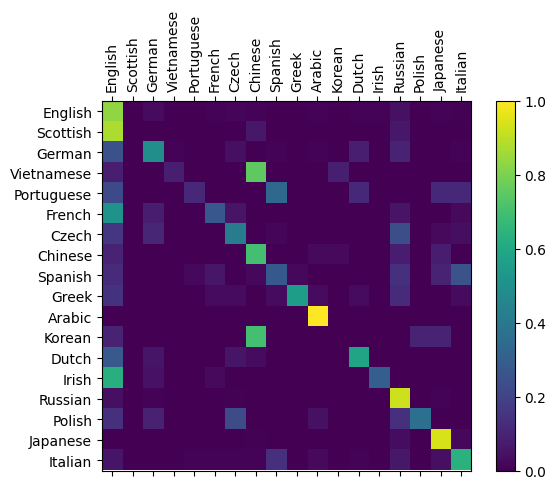

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(lstm, test_set, classes=alldata.labels_uniq)